In [1]:
# notebook last tested with abtem version 1.0.0beta7

from abtem import __version__
print('current version:', __version__)

from ase import build
import matplotlib.pyplot as plt

import numpy as np
from abtem import *
import dask.array as da
import dask


import os
os.environ["MKL_NUM_THREADS"] = "1"

current version: 1.0.0beta22


# Large CBED simulation

In this example we calculate a CBED pattern with a sample consisting of silicon with 8.1 million atoms and a potential discretized on 10000x4096x4096 voxels. On our system the simulation time was 2 min on a single NVidia RTX 2080 Ti.

In [2]:
#from dask.distributed import Client

from dask_cuda import LocalCUDACluster
from dask.distributed import Client

cluster = LocalCUDACluster(memory_limit='9gb', n_workers=1)
client = Client(cluster)

C:\Users\jacob\anaconda3\envs\abtem-dask-gpu\lib\site-packages\distributed\node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 53075 instead
  warnings.warn(
C:\Users\jacob\anaconda3\envs\abtem-dask-gpu\lib\site-packages\dask_cuda\utils.py:168: UserWarning: Cannot get CPU affinity for device with index 0, setting default affinity
  warnings.warn(


In [3]:
silicon = build.bulk('Si', crystalstructure='diamond', cubic=True)
silicon *= (74,74,185)

In [4]:
%%time
from abtem.waves.multislice import multislice
import cupy as cp

fp = FrozenPhonons(silicon, 1, {'Si':.0}, directions='xyz')

potential = Potential(fp, 
                      gpts=4096,
                      device='gpu',
                      projection='infinite', 
                      slice_thickness=.1,
                      precalculate=False)

wave = Probe(energy=100e3, semiangle_cutoff=9.4, device='gpu', rolloff=1)

wave.grid.match(potential)

wave = wave.build((0,0))

exit_wave = wave.multislice(potential)

exit_wave = exit_wave.diffraction_patterns(max_angle='cutoff').mean(0)

AttributeError: 'tuple' object has no attribute 'map_blocks'

(-25.0, 25.0)

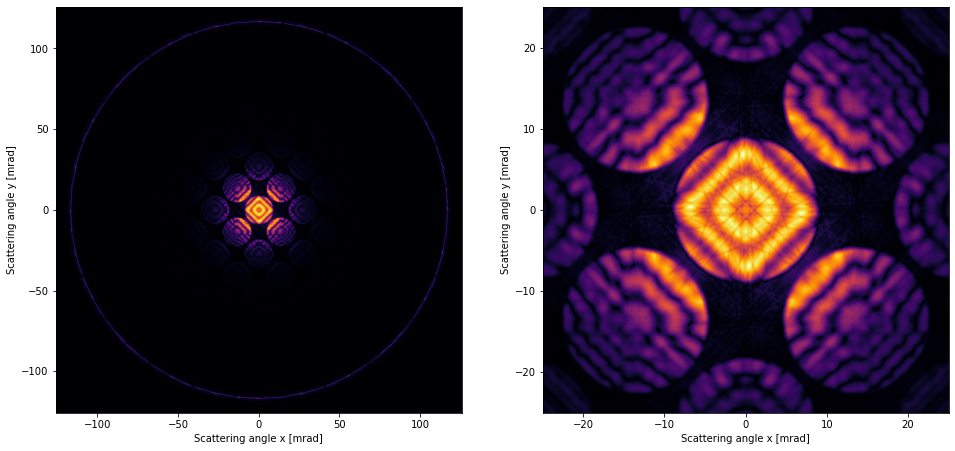

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
exit_wave.show(ax=ax1, power=.5, cmap='inferno')
exit_wave.show(ax=ax2, power=.5, cmap='inferno')

ax2.set_xlim([-25,25])
ax2.set_ylim([-25,25])